In [83]:
import os 
import cv2
import pandas as pd
import numpy as np

In [84]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [85]:
from tqdm import tqdm

In [86]:
import matplotlib.pyplot as plt 

In [87]:
import keras 
from keras.applications.vgg16 import VGG16, preprocess_input


In [88]:
from keras.preprocessing.image import ImageDataGenerator


In [89]:
from keras.applications import ResNet50

2,3.Normalisez les images

In [90]:

def processing_images(state,tensor=None,model=None):
    list_img_array = []
    for i in tqdm(range(len(os.listdir(f'F:\code\malaria_project\malaria_hematie_dataset\{state}')[::4]))):
            path = os.path.join(f'F:\code\malaria_project\malaria_hematie_dataset\{state}',os.listdir(f'F:\code\malaria_project\malaria_hematie_dataset\{state}')[i])

            
            gray_scale = cv2.IMREAD_GRAYSCALE if tensor is None else cv2.IMREAD_COLOR
            img = cv2.imread(path, gray_scale) #

            # Define the desired size
            desired_width = 64
            desired_height = 64

            # Resize the image
            resized_image = cv2.resize(img, (desired_width, desired_height))
            
            list_img_array.append(resized_image)
    return list_img_array





def norm(array,model=None):
    if model==None:
                images_n_array = array.astype("float32") / 255.0
    if model=='vgg16':
            images_n_array = preprocess_input(array)
    return images_n_array

In [91]:
list_img_parasitized = processing_images('parasitized',tensor=1)

list_img_uninfected = processing_images('uninfected',tensor=1)


100%|██████████| 3445/3445 [02:49<00:00, 20.32it/s]


In [92]:
main_list = list_img_parasitized + list_img_uninfected #concatenation 2 list
main_list = np.array(main_list)
main = norm(main_list)


In [93]:
main.shape

(6890, 64, 64, 3)

In [94]:
label_1 = ['parisitized' for i in range(len(list_img_parasitized))]
label_2 = ['uninfected' for i in range(len(list_img_parasitized))]
labels = label_1 + label_2
                

In [95]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)
labels_encoder = le.fit_transform(labels)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(main, labels_encoder, test_size = 0.15, random_state = 309)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5856, 64, 64, 3), (1034, 64, 64, 3), (5856,), (1034,))

data augmentaion

In [97]:
datagen=ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2,  
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,)

In [98]:
train_data_generator=datagen.flow_from_directory(directory="malaria_hematie_dataset",
                                                 target_size=(64,64),
                                                 class_mode='binary',
                                                 subset='training')

Found 22048 images belonging to 2 classes.


In [99]:
def show_cell(images):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0][0])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

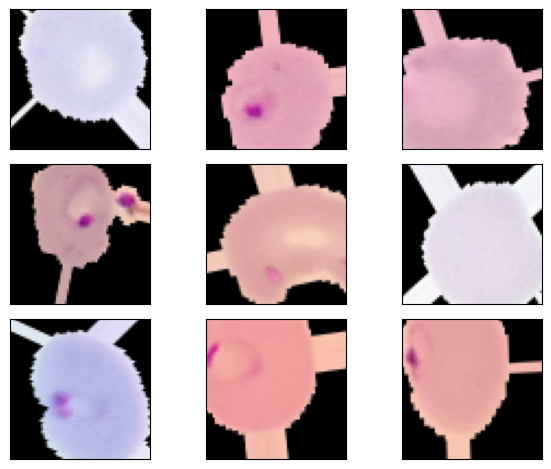

In [100]:
show_cell(train_data_generator)

II.Entrainement de 3 modeles

In [101]:
learning_rate_decay = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

In [102]:
model_scratch = keras.Sequential(
  [
      # Feature learning ~ Encoder
      keras.Input(shape=(64,64,3)),
      keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
      keras.layers.MaxPooling2D(pool_size=(2,2)),


      keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
      keras.layers.MaxPooling2D(pool_size=(2,2)),


      # connexion encoder <-> classifier
      keras.layers.Flatten(),

      # Classifier ~ Fully connected
      keras.layers.Dense(128, activation="relu"),
      keras.layers.Dropout(0.5),

      keras.layers.Dense(1, activation="sigmoid")

  ]
) 

In [103]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
 
model_scratch.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
model_scratch.fit(X_train, y_train, epochs = 30,callbacks=[early_stopping,learning_rate_decay], validation_split=0.15)


Epoch 1/30
156/156 [==============================] - 3s 15ms/step - loss: 0.6813 - accuracy: 0.5686 - val_loss: 0.6487 - val_accuracy: 0.6257 - lr: 1.0000e-04
Epoch 2/30
156/156 [==============================] - 2s 12ms/step - loss: 0.6250 - accuracy: 0.6508 - val_loss: 0.6091 - val_accuracy: 0.6644 - lr: 1.0000e-04
Epoch 3/30
156/156 [==============================] - 2s 12ms/step - loss: 0.6017 - accuracy: 0.6837 - val_loss: 0.5847 - val_accuracy: 0.6792 - lr: 1.0000e-04
Epoch 4/30
156/156 [==============================] - 2s 11ms/step - loss: 0.5855 - accuracy: 0.6994 - val_loss: 0.5957 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 5/30
156/156 [==============================] - 2s 11ms/step - loss: 0.5709 - accuracy: 0.7127 - val_loss: 0.5456 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 6/30
156/156 [==============================] - 2s 14ms/step - loss: 0.5509 - accuracy: 0.7298 - val_loss: 0.5498 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 7/30
156/156 [====================

Import model VGG16, transfert learning (encodeur + fully classified)

In [104]:
encodeur = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
encodeur.trainable = False

model_vgg16_tl = keras.Sequential(
    [
        encodeur,
        keras.layers.Flatten(),
        keras.layers.Dense(1500, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(150, activation='relu'),
        keras.layers.Dense(1, "sigmoid")
    ]
)

In [105]:
model_vgg16_tl.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 1500)              3073500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_9 (Dense)             (None, 150)               225150    
                                                                 
 dense_10 (Dense)            (None, 1)                 151       
                                                                 
Total params: 18,013,489
Trainable params: 3,298,801
N

In [106]:
main = list_img_parasitized + list_img_uninfected
main = norm(np.array(main), model='vgg16') #normalisation differente que celle dans le permier modele
X_train, X_test, y_train, y_test = train_test_split(main, labels_encoder, test_size = 0.15, random_state = 309)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5856, 64, 64, 3), (1034, 64, 64, 3), (5856,), (1034,))

Image preprocess for VGG16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


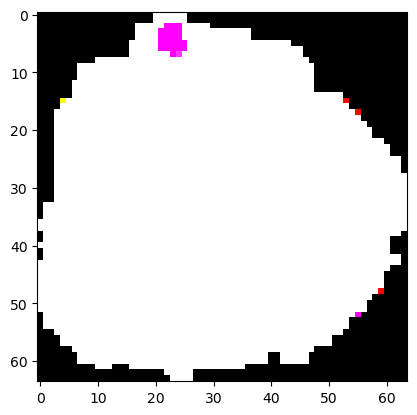

In [107]:
num = 8
print(y_train[num])
plt.imshow(X_train[num])

Fit model vgg16

In [108]:

model_vgg16_tl.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_vgg16_tl.fit(X_train, y_train, epochs = 5)

Epoch 1/5
183/183 [==============================] - 6s 23ms/step - loss: 0.6950 - accuracy: 0.8683
Epoch 2/5
183/183 [==============================] - 4s 23ms/step - loss: 0.3357 - accuracy: 0.9088
Epoch 3/5
183/183 [==============================] - 4s 22ms/step - loss: 0.2319 - accuracy: 0.9247
Epoch 4/5
183/183 [==============================] - 4s 22ms/step - loss: 0.1877 - accuracy: 0.9360
Epoch 5/5
183/183 [==============================] - 4s 23ms/step - loss: 0.1580 - accuracy: 0.9474


Import model resnet50, transfert learning (encodeur + fully classified)

In [109]:
resnet = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
    input_shape=(64, 64, 3)
)
model_resnet = keras.Sequential(
    [
        resnet,
        keras.layers.Flatten(),
        keras.layers.Dense(1500, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(150, activation='relu'),
        keras.layers.Dense(1, "sigmoid")
    ]
)

In [110]:

model_resnet.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_resnet.fit(X_train, y_train, epochs = 5)

Epoch 1/5
183/183 [==============================] - 26s 94ms/step - loss: 0.2533 - accuracy: 0.9044
Epoch 2/5
183/183 [==============================] - 17s 95ms/step - loss: 0.0937 - accuracy: 0.9669
Epoch 3/5
183/183 [==============================] - 17s 94ms/step - loss: 0.0763 - accuracy: 0.9761
Epoch 4/5
183/183 [==============================] - 17s 94ms/step - loss: 0.0548 - accuracy: 0.9807
Epoch 5/5
183/183 [==============================] - 17s 95ms/step - loss: 0.0314 - accuracy: 0.9904


Sauvgarde des poids des 3 models

In [111]:
model_scratch.save_weights('model_scratch.weights.h5')

In [112]:
model_vgg16_tl.save_weights('model_vgg16_tl.weights.h5')

In [113]:
model_resnet.save_weights('model_resnet.weights.h5')

III) Test des Modèles

1) Calculer la Matrice de Confusion

33/33 [==============================] - 1s 29ms/step


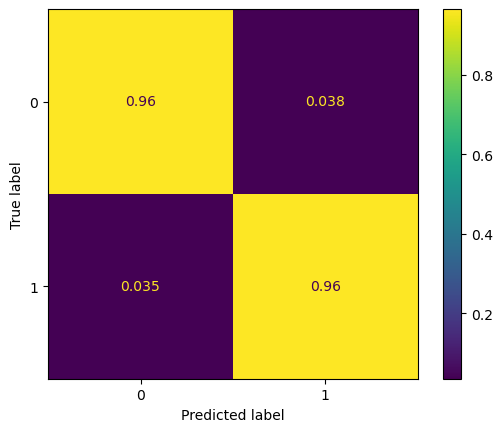

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred_resnet=model_resnet.predict(X_test)
y_pred_resnet[y_pred_resnet <= 0.5] = 0.
y_pred_resnet[y_pred_resnet > 0.5] = 1.
cm=confusion_matrix(y_test, y_pred_resnet, normalize='pred')
cm_display= ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

33/33 [==============================] - 1s 31ms/step


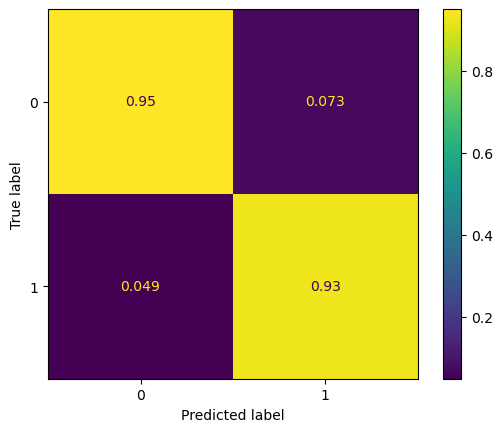

In [116]:

y_pred_vgg16=model_vgg16_tl.predict(X_test)
y_pred_vgg16[y_pred_vgg16 <= 0.5] = 0.
y_pred_vgg16[y_pred_vgg16 > 0.5] = 1.
cm=confusion_matrix(y_test, y_pred_vgg16, normalize='pred')
cm_display= ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

33/33 [==============================] - 0s 5ms/step


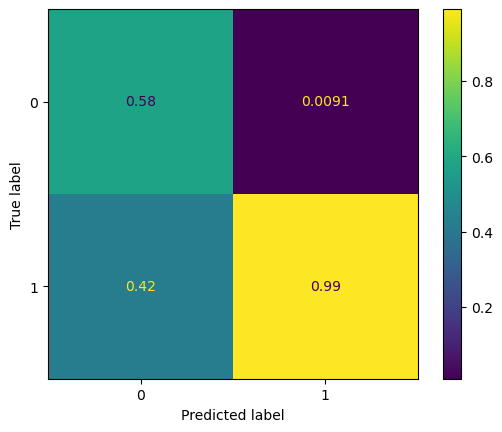

In [117]:
y_pred_scratch=model_scratch.predict(X_test)
y_pred_scratch[y_pred_scratch <= 0.5] = 0.
y_pred_scratch[y_pred_scratch > 0.5] = 1.
cm=confusion_matrix(y_test, y_pred_scratch, normalize='pred')
cm_display= ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

2) Calculer les métriques de performance

métriques de performance pour resnet

In [118]:
from sklearn.metrics import classification_report
target_names = ['parasitized', 'uninfected']
print(classification_report(y_test, y_pred_resnet, target_names=target_names))

              precision    recall  f1-score   support

 parasitized       0.96      0.96      0.96       537
  uninfected       0.96      0.96      0.96       497

    accuracy                           0.96      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.96      0.96      0.96      1034



métriques de performance pour vgg16

In [119]:
print(classification_report(y_test, y_pred_vgg16, target_names=target_names))

              precision    recall  f1-score   support

 parasitized       0.95      0.93      0.94       537
  uninfected       0.93      0.95      0.94       497

    accuracy                           0.94      1034
   macro avg       0.94      0.94      0.94      1034
weighted avg       0.94      0.94      0.94      1034



métriques de performance pour scratch

In [120]:
print(classification_report(y_test, y_pred_scratch, target_names=target_names))

              precision    recall  f1-score   support

 parasitized       0.58      1.00      0.73       537
  uninfected       0.99      0.22      0.36       497

    accuracy                           0.62      1034
   macro avg       0.79      0.61      0.55      1034
weighted avg       0.78      0.62      0.55      1034



3) Afficher le graphique ROC et calculer l’AUC de chacun des 3 modèles.

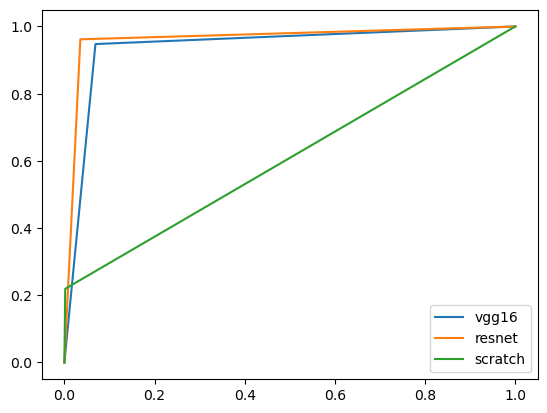

AUC pour vgg16 : 0.939392406581013
AUC pour resnet : 0.9631944366384526
AUC pour scratch : 0.6087268489896548


In [131]:
from sklearn.metrics import roc_auc_score ,roc_curve

fpr_vgg16, tpr_vgg16, thresholds = roc_curve(y_test, y_pred_vgg16)
plt.plot(fpr_vgg16,tpr_vgg16,label="vgg16")
plt.legend(loc=4)
fpr_resnet, tpr_resnet, thresholds = roc_curve(y_test, y_pred_resnet)
plt.plot(fpr_resnet,tpr_resnet,label="resnet")
plt.legend(loc=4)
fpr_scratch, tpr_scratch, thresholds = roc_curve(y_test, y_pred_scratch)
plt.plot(fpr_scratch,tpr_scratch,label="scratch")
plt.legend(loc=4)
plt.show()
print("AUC pour vgg16 :",roc_auc_score(y_test, y_pred_vgg16, average=None))
print("AUC pour resnet :",roc_auc_score(y_test, y_pred_resnet, average=None))
print("AUC pour scratch :",roc_auc_score(y_test, y_pred_scratch, average=None))

Interpretation

Le modèle resnet performe mieux que les autres de par le fait que l'auc est plus grande que celle des concurrents, de plus resnet est supérieur si on décide de maximiser la sensibilité et la spécificité . Le modèle vgg16 est assez proche des performances de resnet mais le Cnn scratch est nettement moins bon.